## Libraries

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import csv

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt

c:\Users\henri\miniconda3\envs\deep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
ds = load_dataset("dair-ai/emotion", "split")

# Task 1: Data Preparation

## Data set size

In [3]:
# Print number of examples
print(f"Number of train examples: {len(ds['train'])}")
print(f"Number of validation examples: {len(ds['validation'])}")
print(f"Number of test examples: {len(ds['test'])}")

Number of train examples: 16000
Number of validation examples: 2000
Number of test examples: 2000


## Step 1: Label distribution

0: sadness
1: joy
2: love
3: anger
4: fear
5: surprise


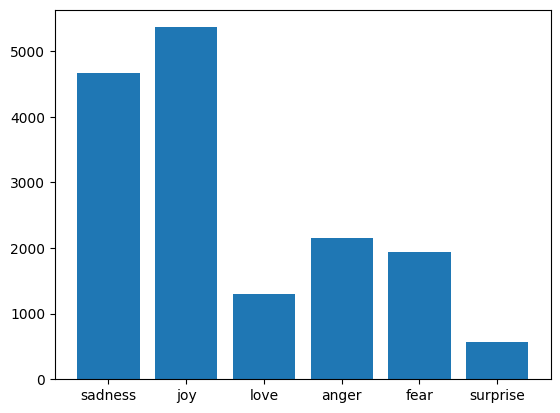

In [4]:
# Print labels and their corresponding index
for i, label in enumerate(ds["train"].features["label"].names):
    print(f"{i}: {label}")

# Plot the distribution of the labels
plt.hist(ds["train"]["label"], bins=range(7), align='left', rwidth=0.8)

# Center the x-axis ticks on the histogram bars
plt.xticks([i for i in range(6)], ds["train"].features["label"].names)

# Display the plot
plt.show()

# Save the number of classes in a variable
num_classes = len(ds["train"].features["label"].names)

# Save label mapping in a variable
label_mapping = {i: label for i, label in enumerate(ds['train'].features['label'].names)}

## Step 2: Extract texts for all splits and split each text into tokens

In [5]:
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+|[!?'´`]+")
example_sentence = "This?.is,a:custom;tokenization example!<"
example_tokens = tokenizer.tokenize(example_sentence)
print(example_tokens)

['This', '?', 'is', 'a', 'custom', 'tokenization', 'example', '!']


In [6]:
train_tokens = [tokenizer.tokenize(example["text"]) for example in ds["train"]]
train_vocab = set(token for tokens in train_tokens for token in tokens)
print(ds["train"][0]["text"])
print(train_tokens[0])

print("")
val_tokens = [tokenizer.tokenize(example["text"]) for example in ds["validation"]]
val_vocab = set(token for tokens in val_tokens for token in tokens)
print(ds["validation"][0]["text"])
print(val_tokens[0])



print("")
test_tokens = [tokenizer.tokenize(example["text"]) for example in ds["test"]]
print(ds["test"][0]["text"])
print(test_tokens[0])


# Compute the difference: Words in training but not in validation
missing_words = train_vocab - val_vocab
# Output the missing words
print(f"Number of words in training vocabulary: {len(train_vocab)}")
print(f"Number of words in validation vocabulary: {len(val_vocab)}")
print(f"Number of words missing in validation: {len(missing_words)}")

with open("missing_words.txt", "w") as file:
    for word in sorted(missing_words):
        file.write(f"{word}\n")

print("Missing words saved to 'missing_words.txt'")

i didnt feel humiliated
['i', 'didnt', 'feel', 'humiliated']

im feeling quite sad and sorry for myself but ill snap out of it soon
['im', 'feeling', 'quite', 'sad', 'and', 'sorry', 'for', 'myself', 'but', 'ill', 'snap', 'out', 'of', 'it', 'soon']

im feeling rather rotten so im not very ambitious right now
['im', 'feeling', 'rather', 'rotten', 'so', 'im', 'not', 'very', 'ambitious', 'right', 'now']
Number of words in training vocabulary: 15212
Number of words in validation vocabulary: 4796
Number of words missing in validation: 11400
Missing words saved to 'missing_words.txt'


Train:
Length range: 2-66
Mean length: 19.1663125
Standard deviation: 120.70452765234376

Validation:
Length range: 2-61
Mean length: 18.866
Standard deviation: 116.86304399999999

Test:
Length range: 3-61
Mean length: 19.154
Standard deviation: 121.211284


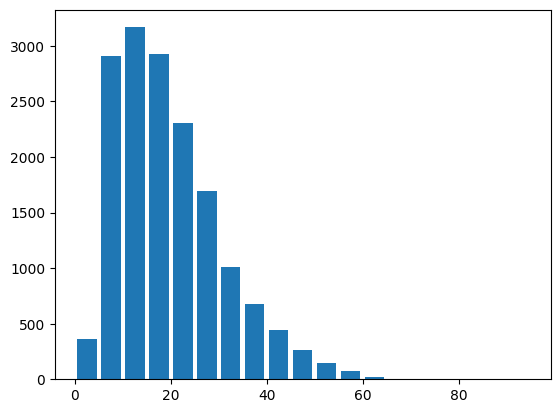

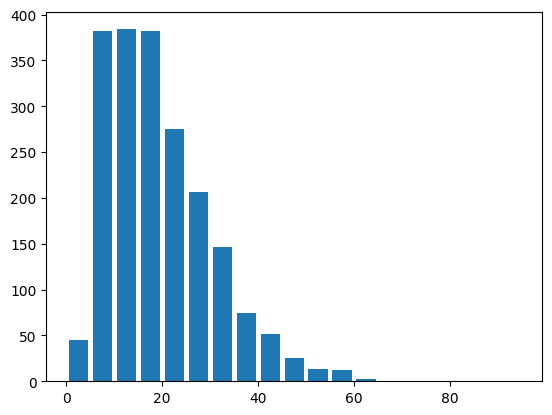

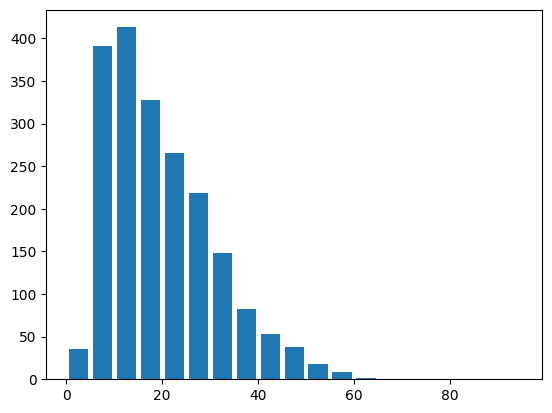

In [7]:
# Distribution of text lengths by providing its range, mean, and standard deviation
train_lengths = [len(tokens) for tokens in train_tokens]
val_lengths = [len(tokens) for tokens in val_tokens]
test_lengths = [len(tokens) for tokens in test_tokens]

print("Train:")
print(f"Length range: {min(train_lengths)}-{max(train_lengths)}")
print(f"Mean length: {sum(train_lengths) / len(train_lengths)}")
print(f"Standard deviation: {sum([(length - sum(train_lengths) / len(train_lengths)) ** 2 for length in train_lengths]) / len(train_lengths)}")

print("\nValidation:")
print(f"Length range: {min(val_lengths)}-{max(val_lengths)}")
print(f"Mean length: {sum(val_lengths) / len(val_lengths)}")
print(f"Standard deviation: {sum([(length - sum(val_lengths) / len(val_lengths)) ** 2 for length in val_lengths]) / len(val_lengths)}")

print("\nTest:")
print(f"Length range: {min(test_lengths)}-{max(test_lengths)}")
print(f"Mean length: {sum(test_lengths) / len(test_lengths)}")
print(f"Standard deviation: {sum([(length - sum(test_lengths) / len(test_lengths)) ** 2 for length in test_lengths]) / len(test_lengths)}")

# Plot the distribution of the text lengths
plt.hist(train_lengths, bins=range(0, 100, 5), rwidth=0.8)
plt.show()

plt.hist(val_lengths, bins=range(0, 100, 5), rwidth=0.8)
plt.show()

plt.hist(test_lengths, bins=range(0, 100, 5), rwidth=0.8)
plt.show()

## Step 3: Build a vocabulary

In [8]:
vocabulary = {"<PAD>": 0, "<UNK>": 1}
for tokens in train_tokens:
    for token in tokens:
        if token not in vocabulary:
            vocabulary[token] = len(vocabulary)
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

reverse_vocab = {v: k for k, v in vocabulary.items()}

Vocabulary size: 15214


## Step 4: Encode all texts with the vocabulary

In [9]:
def encode_text(tokens):
    return [vocabulary[token] if token in vocabulary else 1 for token in tokens]

train_encoded = [encode_text(tokens) for tokens in train_tokens]
val_encoded = [encode_text(tokens) for tokens in val_tokens]
test_encoded = [encode_text(tokens) for tokens in test_tokens]

## Step 5: Maximum sequence length

In [10]:
max_length = 20
def pad_sequence(sequence):
    return sequence[:max_length] + [0] * (max_length - len(sequence))

train_padded = [pad_sequence(sequence) for sequence in train_encoded]
val_padded = [pad_sequence(sequence) for sequence in val_encoded]
test_padded = [pad_sequence(sequence) for sequence in test_encoded]

In [24]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.6)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        last_hidden = self.dropout(output[:, -1, :])
        logits = self.fc(last_hidden)
        return logits

In [12]:
class EmotionDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.LongTensor(self.data[idx]), torch.tensor(self.labels[idx], dtype=torch.long)

In [13]:
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, dim=1)  # Get the index of the highest score (predicted label)
    correct = (predicted == targets).sum().item()  # Count the number of correct predictions
    return correct

In [14]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [40]:
# Filepath for the output CSV
output_filepath = "predictions.csv"

# List to store rows for the CSV
output_rows = [["Sentence", "Correct", "Confidence", "True Label", "Predicted Label"]]

# Training parameters
embedding_dim = 100
hidden_dim = 256
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Create the model
model = TextClassifier(vocab_size, embedding_dim, hidden_dim, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

train_labels = [example["label"] for example in ds["train"]]
val_labels = [example["label"] for example in ds["validation"]]

train_dataset = EmotionDataset(train_padded, train_labels)
val_dataset = EmotionDataset(val_padded, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Put the model on the GPU
model = model.to(device)

# Iterate over the training data for the specified number of epochs
for epoch in range(num_epochs):
    # Training Phase
    
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_correct += calculate_accuracy(outputs, targets)
        total_samples += inputs.size(0)
    
    train_loss = total_loss / total_samples
    train_accuracy = total_correct / total_samples  * 100

    # Validation Phase
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            
            # Apply softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)
            
            # Get the predicted labels and confidence scores
            confidences, predicted = torch.max(probabilities, dim=1)
            
            # Get the original sentences for the current batch
            batch_start_idx = batch_idx * valid_loader.batch_size
            original_sentences = ds["validation"][batch_start_idx:batch_start_idx + len(inputs)]["text"]
            
            # Iterate through the batch and collect data
        for i in range(len(inputs)):
            original_sentence = original_sentences[i]
            true_label = label_mapping[targets[i].item()]  # Convert true label to text
            predicted_label = label_mapping[predicted[i].item()]  # Convert predicted label to text
            confidence = confidences[i].item()
            is_correct = true_label == predicted_label

            # Tokenize the original sentence
            tokens = tokenizer.tokenize(original_sentence)
            unknown_words = [token for token in tokens if token not in vocabulary]

            # Add to output rows
            output_rows.append([
                original_sentence,
                true_label,
                predicted_label,
                confidence,
                is_correct,
                ", ".join(unknown_words)  # Join unknown words into a single string
            ])
            
            val_loss = criterion(outputs, targets)

            total_val_loss += val_loss.item() * inputs.size(0)
            total_val_correct += calculate_accuracy(outputs, targets)
            total_val_samples += inputs.size(0)
    
    val_accuracy = total_val_correct / total_val_samples * 100
    val_loss = total_val_loss / total_val_samples
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}, "
          f"Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.2f}")

# Write to CSV
with open(output_filepath, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerows(output_rows)

Epoch 1/10, Train Loss: 1.593, Train Accuracy: 33.14, Val Loss: 1.607, Val Accuracy: 37.50
Epoch 2/10, Train Loss: 1.513, Train Accuracy: 38.91, Val Loss: 1.390, Val Accuracy: 37.50
Epoch 3/10, Train Loss: 0.911, Train Accuracy: 66.77, Val Loss: 0.871, Val Accuracy: 68.75
Epoch 4/10, Train Loss: 0.462, Train Accuracy: 84.06, Val Loss: 0.845, Val Accuracy: 75.00
Epoch 5/10, Train Loss: 0.307, Train Accuracy: 89.08, Val Loss: 0.672, Val Accuracy: 75.00
Epoch 6/10, Train Loss: 0.241, Train Accuracy: 91.16, Val Loss: 1.132, Val Accuracy: 68.75
Epoch 7/10, Train Loss: 0.188, Train Accuracy: 93.15, Val Loss: 0.772, Val Accuracy: 81.25
Epoch 8/10, Train Loss: 0.146, Train Accuracy: 94.76, Val Loss: 0.918, Val Accuracy: 87.50
Epoch 9/10, Train Loss: 0.119, Train Accuracy: 95.81, Val Loss: 0.656, Val Accuracy: 75.00
Epoch 10/10, Train Loss: 0.096, Train Accuracy: 96.69, Val Loss: 1.208, Val Accuracy: 68.75


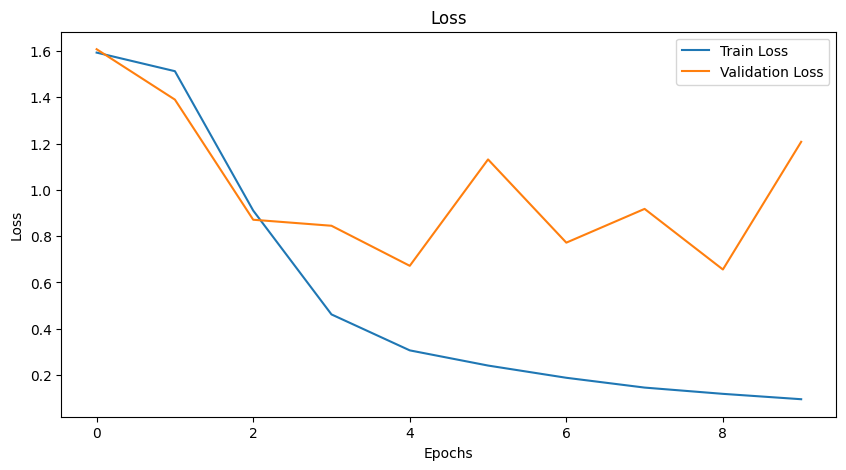

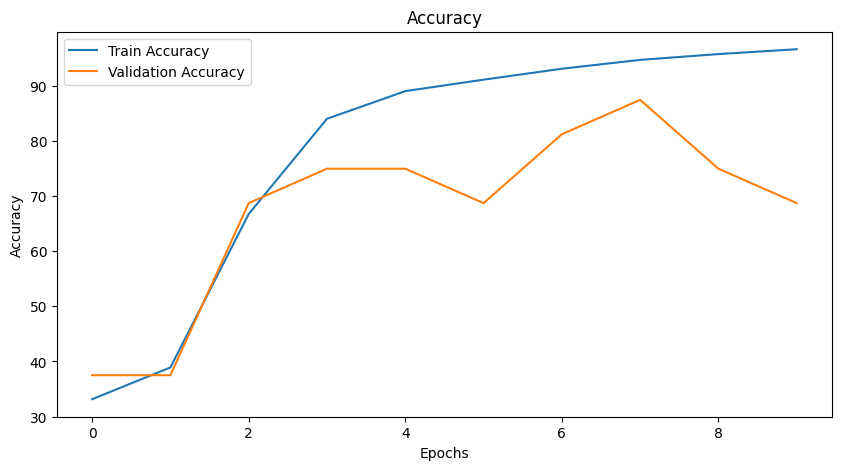

In [41]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()